In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [54]:
np.random.seed(8999)
torch.manual_seed(8999)

In [55]:
def data_generator(number_samples: int, max_len_input_sequence: int) -> tuple[list, list]:
    # Initialize lists to store sequences and their corresponding sums
    sequences = []
    sums = []
    
    for _ in range(number_samples):
        # Generate a random sequence length
        seq_len = np.random.randint(2, max_len_input_sequence + 1)
        
        # Create the sequence with random values in the first dimension
        sequence = np.zeros((seq_len, 2))
        sequence[:, 0] = np.random.rand(seq_len)
        
        # Randomly choose two distinct positions for the markers
        markers = np.random.choice(seq_len, 2, replace=False)
        sequence[markers, 1] = 1
        
        # Calculate the sum of the marked values
        sum_values = np.sum(sequence[markers, 0])
        
        # Append the sequence and its sum to the respective lists
        sequences.append(sequence)
        sums.append(sum_values)
    
    # Convert lists to NumPy arrays for efficient processing in training
    sequences = np.array(sequences, dtype=object)  # Use dtype=object for variable-length sequences
    sums = np.array(sums)
    
    return sequences, sums

In [64]:
np.random.seed(8999)
torch.manual_seed(8999)
# Here I have define the simple input arrays 
X,Y = [],[]

# Length of indivisual data point 
LOW_LIM = 2
UPR_LIM = 9

# I have taken the 5000 data points
for _ in range(5000):
  # Randomly select length
  LEN = np.random.randint(LOW_LIM,UPR_LIM)
  # Random points of selected size, value between one and zero
  D1 = np.random.random((LEN)).astype(np.double)
  D2 = np.zeros(LEN)
  # Randomly seet 2 positions as one.
  ONEs = np.random.randint(LEN,size=(2))
  while ONEs[0] == ONEs[1]:
    ONEs = np.random.randint(LEN,size=(2))
  D2[ONEs] = 1
  
  # Append to Data array after coverting to tensor.
  X.append(torch.from_numpy(np.array([(D1[i] , D2[i]) for i in range(LEN)])).double())
  Y.append(torch.from_numpy(np.array([ D1[ONEs[0]] + D1[ONEs[1]] ])))

# Converting to numpy array
X = X.test
Y = np.array(Y)

# Printing the shapes
X.shape,Y.shape

C:\Users\gupta\AppData\Local\Temp\ipykernel_3012\4155259752.py:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(X)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5000,) + inhomogeneous part.

In [57]:
# Generate data
sequences, sums = data_generator(5000, 10)

# Example usage: print the first sample
print(sequences[0])
print("Sum:", sums[0])

[[0.96502213 1.        ]
 [0.0981797  0.        ]
 [0.98720149 1.        ]
 [0.65550495 0.        ]]
Sum: 1.9522236228990744


In [58]:
def train_test_split(X: list, Y: list, percentage_test: float=0.3) -> tuple[list, list, list, list]:
    # Ensure X and Y are numpy arrays for consistent handling
    X = np.array(X)
    Y = np.array(Y)
    
    # Generate a permutation of indices based on the length of X
    indices = np.random.permutation(len(X))
    
    # Calculate the split index
    split_idx = int(len(X) * (1 - percentage_test))
    
    # Use the generated indices to shuffle X and Y in a synchronized manner
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    
    # Split the data into training and test sets
    X_train = X_shuffled[:split_idx]
    X_test = X_shuffled[split_idx:]
    Y_train = Y_shuffled[:split_idx]
    Y_test = Y_shuffled[split_idx:]
    
    return X_train, X_test, Y_train, Y_test


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences, sums)


# Convert lists of sequences into lists of tensors
X_train_t = [torch.tensor(s, dtype=torch.float32) for s in X_train]
X_test_t = [torch.tensor(s, dtype=torch.float32) for s in X_test]

# Pad sequences
X_train_padded = nn.utils.rnn.pad_sequence(X_train_t, batch_first=True)
X_test_padded = nn.utils.rnn.pad_sequence(X_test_t, batch_first=True)

# Your labels (Y_train and Y_test) likely don't need padding if they're already in a compatible format
# If they're not simple scalars or fixed-size vectors per sample, adjust accordingly
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)


#To GPU
# X_train_padded = X_train_padded.to(device)
# X_test_padded = X_test_padded.to(device)

# Y_train_t = Y_train_t.to(device)
# Y_test_t = Y_test_t.to(device)


In [61]:
class ElmonRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(ElmonRNN, self).__init__()
        # Only one layer now
        self.W_hx = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_hy = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # Assuming x of shape (batch_size, seq_len, input_size)
        h_t = self.tanh(self.W_hx(x) + self.W_hh(hidden))
        output = self.W_hy(h_t)
        return output, h_t


In [62]:


# Adjusted model initialization for single-layer
elmonModel = ElmonRNN(2, 10, 1)#.to(device)  # Initialize the model with input_size=2, hidden_size=4, output_size=1

loss_fun = nn.MSELoss()  # Loss function
optimizer = optim.Adam(elmonModel.parameters(), lr=0.005)  # Optimizer

losses_elmon = []  # List to store loss values
epochs = 25
for epoch in tqdm(range(epochs)):
    losses = []
    for x, y in zip(X_train_t, Y_train_t):
        elmonModel.zero_grad()
        hidden_state = torch.zeros(1, 10, requires_grad=False)#.to(device)
        # x,y = x.to(device), y.to(device)
        output = 0 #need ot change
        for i in range(x.shape[0]):
            output, hidden_state = elmonModel(x[i,:], hidden_state)        
        losses.append(loss.item())
        loss = loss_fun(output, Y_train_t)
        loss.backward()  # Backward pass
        nn.utils.clip_grad_norm_(elmonModel.parameters(), max_norm=1)  # Clip gradients to prevent exploding gradient problem
        optimizer.step()  # Update model parameters
    losses_elmon.append(torch.tensor(losses).mean())  # Collect the loss for plotting
    
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


  4%|▍         | 1/25 [00:03<01:24,  3.53s/it]

Epoch 1, Loss: 0.16447380185127258


100%|██████████| 25/25 [01:25<00:00,  3.41s/it]


In [36]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

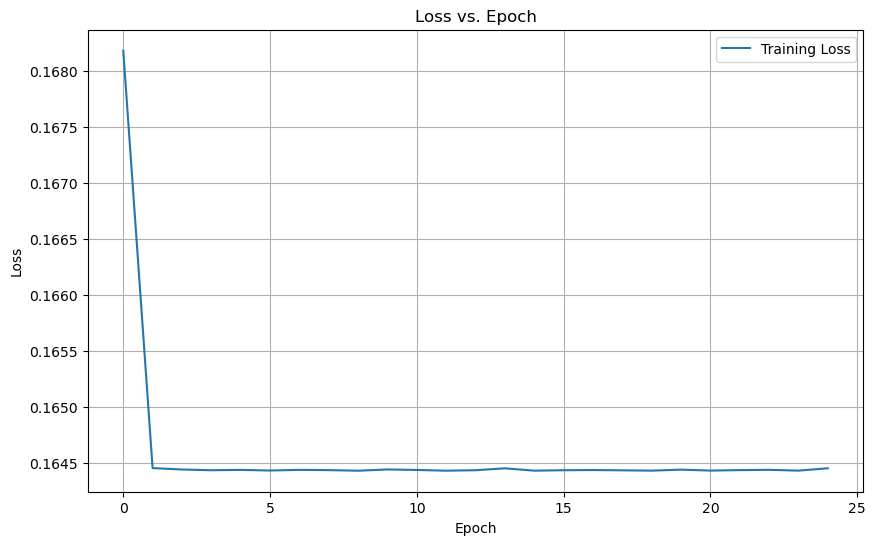

In [63]:
plot_loss(losses_elmon)

In [23]:
import torch
import torch.nn as nn

class SingleLayerLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(SingleLayerLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # Gates initialization
        self.W_xi = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        self.W_ci = nn.Linear(hidden_size, hidden_size)
        
        self.W_xf = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size)
        self.W_cf = nn.Linear(hidden_size, hidden_size)
        
        self.W_xo = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size)
        self.W_co = nn.Linear(hidden_size, hidden_size)
        
        self.W_xc = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden and cell states
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # Process each time step
        for i in range(x.size(1)):  # Assuming x is of shape (batch, seq_len, input_size)
            x_t = x[:, i, :]
            
            # LSTM cell calculations
            i_t = self.sigmoid(self.W_xi(x_t) + self.W_hi(h_t) + self.W_ci(c_t))
            f_t = self.sigmoid(self.W_xf(x_t) + self.W_hf(h_t) + self.W_cf(c_t))
            o_t = self.sigmoid(self.W_xo(x_t) + self.W_ho(h_t) + self.W_co(c_t))
            c_tilda = self.tanh(self.W_xc(x_t) + self.W_hc(h_t))
            
            c_t = f_t * c_t + i_t * c_tilda
            h_t = o_t * self.tanh(c_t)
                
        # Decode the hidden state of the last time step
        output = self.sigmoid(self.W_hy(h_t))
        return output


In [24]:
import torch.optim as optim

# Adjusted model initialization for single-layer LSTM
lstmModel = SingleLayerLSTM(2, 10, 1).to(device)  # Initialize the model with input_size=2, hidden_size=4, output_size=1

loss_fun = nn.MSELoss()  # Loss function
optimizer = optim.Adam(lstmModel.parameters(), lr=0.005)  # Optimizer

losses_LSTM = []  # List to store loss values
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero the gradients
    output = lstmModel(X_train_padded)
    loss = loss_fun(output, Y_train_t)
    losses_LSTM.append(loss.item())  # Collect the loss for plotting
    loss.backward()  # Backward pass
    nn.utils.clip_grad_norm_(lstmModel.parameters(), max_norm=1)  # Clip gradients to prevent exploding gradient problem
    optimizer.step()  # Update model parameters
    
    if epoch % 100 == 0:  # Optionally, print loss every 100 epochs to monitor progress
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


c:\Users\gupta\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3500])) that is different to the input size (torch.Size([3500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.4277397692203522
Epoch 101, Loss: 0.16775259375572205
Epoch 201, Loss: 0.16631343960762024
Epoch 301, Loss: 0.16588282585144043
Epoch 401, Loss: 0.16568638384342194
Epoch 501, Loss: 0.1655769646167755
Epoch 601, Loss: 0.16550832986831665
Epoch 701, Loss: 0.16546176373958588
Epoch 801, Loss: 0.16542832553386688
Epoch 901, Loss: 0.16540327668190002


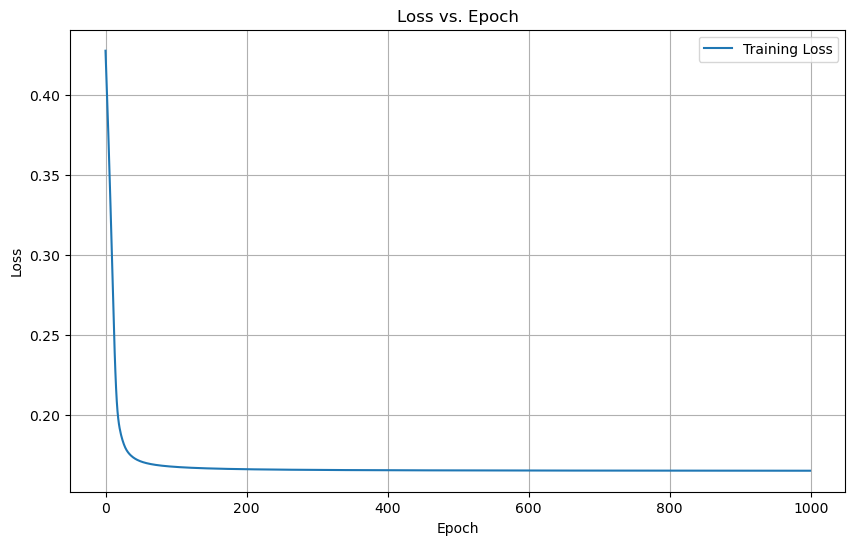

In [25]:
plot_loss(losses_LSTM)

In [26]:
import torch
import torch.nn as nn

class SingleLayerGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(SingleLayerGRU, self).__init__()
        self.hidden_size = hidden_size
        
        # Initialize weights for GRU gates
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)  # Update gate weights
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)  # Reset gate weights
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)  # Candidate hidden state weights
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Batch size for dynamic batch sizing
        batch_size = x.size(0)
        
        # Initialize hidden state
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # Process each time step
        for i in range(x.size(1)):  # Assuming x is of shape (batch, seq_len, input_size)
            x_t = x[:, i, :]
            
            # Concatenate x_t and previous hidden state
            combined = torch.cat((x_t, h_t), 1)
            
            # GRU calculations
            z_t = self.sigmoid(self.W_z(combined))
            r_t = self.sigmoid(self.W_r(combined))
            combined_reset = torch.cat((x_t, r_t * h_t), 1)
            h_t_tilda = self.tanh(self.W_h(combined_reset))
            h_t = (1 - z_t) * h_t + z_t * h_t_tilda
        
        # Decode the hidden state of the last time step
        output = self.W_hy(h_t)
        return output


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming SingleLayerGRU is your custom single-layer GRU model
# Initialize the GRU model with specified parameters
gruModel = SingleLayerGRU(input_size=2, hidden_size=10, output_size=1).to(device)  
loss_fun = nn.MSELoss()  # Loss function
optimizer = optim.Adam(gruModel.parameters(), lr=0.005)  # Optimizer

losses_GRU = []  # List to store loss values
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero the gradients
    output = gruModel(X_train_padded)  # Use your padded input suitable for GRU
    loss = loss_fun(output, Y_train_t)  # Use your target tensor
    losses_GRU.append(loss.item())  # Collect the loss for plotting
    loss.backward()  # Perform the backward pass
    nn.utils.clip_grad_norm_(gruModel.parameters(), max_norm=1)  # Gradient clipping to avoid exploding gradients
    optimizer.step()  # Update model parameters with gradients
    
    if epoch % 100 == 0:  # Optionally, print loss every 100 epochs for monitoring
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 1.2635573148727417
Epoch 101, Loss: 0.16649584472179413
Epoch 201, Loss: 0.1653113067150116
Epoch 301, Loss: 0.16526007652282715
Epoch 401, Loss: 0.16524606943130493
Epoch 501, Loss: 0.16523872315883636
Epoch 601, Loss: 0.16523520648479462
Epoch 701, Loss: 0.16523361206054688
Epoch 801, Loss: 0.16523291170597076
Epoch 901, Loss: 0.1652325689792633


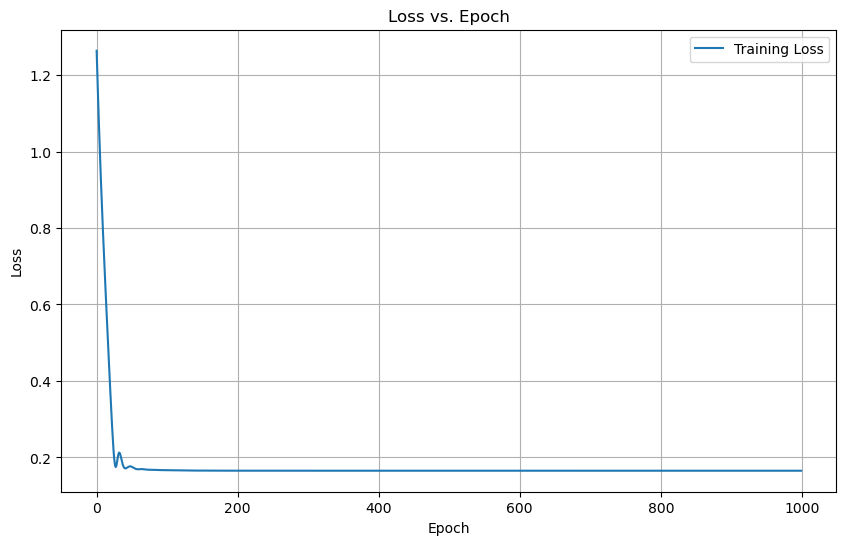

In [28]:
plot_loss(losses_GRU)

In [29]:
def evaluate_model(model, X_test_padded, Y_test_t, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        predictions = model(X_test_padded)
        mse_loss = nn.MSELoss()
        loss = mse_loss(predictions, Y_test_t)
        rmse = np.sqrt(loss.item())  # Calculate the RMSE

    print(f'RMSE: {rmse}')
    return rmse

# Example usage:
rmse_gru = evaluate_model(gruModel, X_test_padded, Y_test_t, device)
rmse_lstm = evaluate_model(lstmModel, X_test_padded, Y_test_t, device)
rmse_elmon = evaluate_model(elmonModel, X_test_padded, Y_test_t, device)


RMSE: 0.4116193922919498
RMSE: 0.41160306517735895


c:\Users\gupta\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1500])) that is different to the input size (torch.Size([1500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: ElmonRNN.forward() missing 1 required positional argument: 'hidden'

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
    
    def forward(self, x):
        batch_size = x.size(0)  # x is the input data
        predictions = torch.ones(batch_size, 1, device=x.device)  # Always predict a sum of 1
        return predictions


In [ ]:
baseline_model = BaselineModel().to(device)

# Loss function
criterion = nn.MSELoss()

# Since there's no learning, we don't need an optimizer for the baseline model

def calculate_loss_for_baseline(model, X, Y):
    # Baseline model does not need training, so we directly calculate loss
    model.eval()  # Put model in evaluation mode
    with torch.no_grad():
        predictions = model(X)
        loss = criterion(predictions.squeeze(), Y)
    return loss.item()

# Calculate baseline loss
losses_baseline = []
epoch = 1000
for _ in range(epoch):
    baseline_loss_train = calculate_loss_for_baseline(baseline_model, X_train_padded, Y_train_t)
    losses_baseline.append(baseline_loss_train)




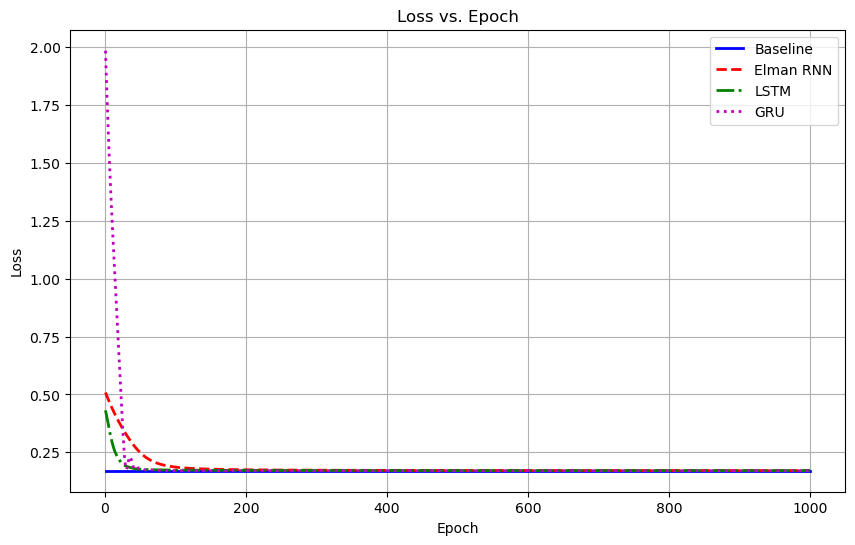

In [ ]:
epochs = list(range(1, epoch + 1))

plt.figure(figsize=(10, 6))

# Plot for baseline
plt.plot(epochs, losses_baseline, 'b-', label='Baseline', linewidth=2)

# Assuming these variables (losses_elmon, losses_LSTM, losses_GRU) are defined elsewhere in your code
# with their respective loss values. You can adjust the line styles and colors as needed.
plt.plot(epochs, losses_elmon, 'r--', label='Elman RNN', linewidth=2)  # Dashed line for Elman RNN
plt.plot(epochs, losses_LSTM, 'g-.', label='LSTM', linewidth=2)  # Dash-dot line for LSTM
plt.plot(epochs, losses_GRU, 'm:', label='GRU', linewidth=2)  # Dotted line for GRU

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Read the image
image_path = "IITH_logo.png"
image = plt.imread(image_path)
# If the image has an alpha channel, you might want to remove it or convert the image to grayscale
if image.shape[2] == 4:
    image = image[:, :, :3]

print("Original image shape:", image.shape)


# Define a kernel for convolution (example: a simple 3x3 averaging kernel)
kernel = np.ones((100, 100, 3)) / 9

# Define the stride and padding
stride = 1
padding = 1

# Call the convolution function
result = convolution_fun(image, kernel, stride, padding, relu)

print("Result shape:", result.shape)

# Normalize the result for display purposes
result_normalized = result - result.min()
result_normalized = result_normalized / result_normalized.max()

# Display the image inline
plt.imshow(result_normalized.squeeze())#, cmap='gray')
plt.axis('off')  # Optional: to not display axes for cleaner visualization
plt.show()